# Identification
Please indicate your name

Student 1: Nesrine Naaman (DIGIT)

Student 2: Nguyen Huong Giang LE (DIGIT)

# Practical work 6 : Harris Corner Detector

The goal of this pratical work is to implement the Harris-Stephen's corners detector (C. Harris and M. Stephens. A combined corner and edge detector. In Proc. Fourth Alvey Vision Conference, pages 147–151, 1988).

Recall the Harris detector computes a map of corners from an image $I$:
$$
R(x,y) = \operatorname{det}(M) - k (\operatorname{trace}(M))^2, (x,y) \text{pixels}
$$
with $k\in[0.04, 0.06]$. $M$ is the auto-correlation of image $I$:
$$
M=\begin{pmatrix}
\sum_{x,y \in W} w(x,y)I_x^2 &
\sum_{x,y \in W} w(x,y)I_xI_y \\
\sum_{x,y \in W} w(x,y)I_xI_y &
\sum_{x,y \in W} w(x,y)I_y^2 
\end{pmatrix}
=\begin{pmatrix}
A & B \\ C & D
\end{pmatrix}
$$
with $w(x,y)=\frac1{2\pi \sigma^2}e^{\frac{(x-x_c)^2 + (y-y_c)^2}{2\sigma^2}}$ a Gaussian mask centered on the window $W$. Partial derivatives $I_x$ and $I_y$ are estimated by one of the following kernels :
- Gradient:  $G_x = \begin{pmatrix} 0 & 0 & 0\\ 1 & 0 &-1 \\ 0 & 0 & 0 \end{pmatrix}$,
 $G_y = G_x^T$
- Prewitt: $G_x = \begin{pmatrix} 1 & 0 & -1\\ 1 & 0 &-1 \\ 1 & 0 & -1 \end{pmatrix}$,
 $G_y = G_x^T$
- Sobel: $G_x = \begin{pmatrix} 1 & 0 & -1\\ 2 & 0 &-2 \\ 1 & 0 & -1 \end{pmatrix}$,
 $G_y = G_x^T$
 


In [59]:
# Load useful libraries
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import convolve2d


# Useful functions 
def gaussianKernel(sigma):
    """ double -> Array
        return a gaussian kernel of standard deviation sigma
    """
    n2 = int(np.ceil(3*sigma))
    x,y = np.meshgrid(np.arange(-n2,n2+1),np.arange(-n2,n2+1))
    kern = np.exp(-(x**2+y**2)/(2*sigma*sigma))
    return  kern/kern.sum()

## Exercise 1: Harris response calculation

1) Write a function `computeR(I, scale, kappa)` that returns the Harris response $R$ from an image $I$ and a scale $scale$. You will use 5 steps:
- Computation of the directionnal derivate $I_x$ and $I_y$. Use the Sobel kernel.
- Computation of the products $I_x^2$, $I_y^2$, $I_x.I_y$.
- Computation of the convolution of $I_x^2$, $I_y^2$ and $I_x.I_y$ by a gaussian kernel of size N (use given function `gaussianKernel()`)
- Computation of $\operatorname{det}(M(x,y))$ and $\operatorname{trace}(M(x,y))$ for each pixel
- Computation of $R(x,y) = \operatorname{det}(M(x,y)) - k.(\operatorname{trace}(M(x,y)))^2$. You can use $k = 0.04$.

 You can compute the convolutions by using the ```scipy.signal.convolve2d``` function. 


In [60]:
def computeR(image,scale,kappa):
    """ Array[n, m]*float*float->Array[n, m]
    """
    # 1. Compute directional derivate Ix and Iy. Use Sobel Kernel
    Sobel_x = np.array([[1, 0, -1],
                       [2, 0, -2],
                       [1, 0, -1]])
    Sobel_y = Sobel_x.T
    Ix = convolve2d(image,Sobel_x,mode="same")
    Iy = convolve2d(image,Sobel_y,mode="same")

    # 2. Compute the products Ix^2, Iy^2, Ix.Iy
    Ix_2 = Ix **2
    Iy_2 = Iy **2
    IxIy = Ix * Iy

    # 3. Compute the convolution by gaussian kernel of size N
    sigma = (scale-1)/6
    gaussian = gaussianKernel(sigma)
    Ix_2_g = convolve2d(Ix_2, gaussian, mode="same")
    Iy_2_g = convolve2d(Iy_2, gaussian, mode="same")
    IxIy_g = convolve2d(IxIy, gaussian, mode="same")

    # 4. Compute det(M) and trace(M)
    det = Ix_2_g*Iy_2_g - IxIy_g**2
    trace = Ix_2_g + Iy_2_g

    # compute R
    R = det - kappa * trace**2
    return R

2) Write a script that displays the Harris response for the image ```img/house2.png``` along with the original image. Use a gaussian window of size $W=15$ pixels.

In [61]:
def imshow(I, title=None, size=500, axis=False):
    """ display an image, with title, size, and axis """
    plt.figure(figsize=(size//80, size//80))
    plt.gray()
    plt.imshow(I)
    if not axis: plt.axis('off')
    if title: plt.title(title)
    plt.show()

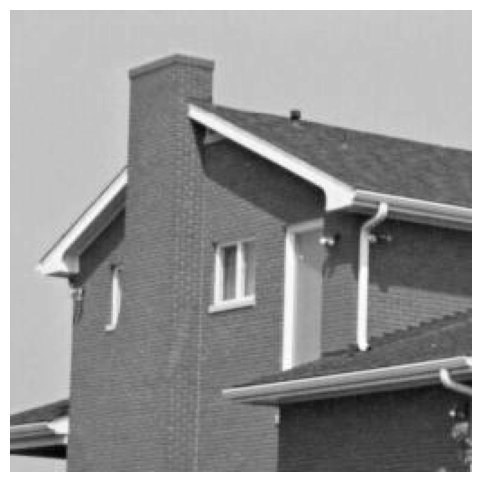

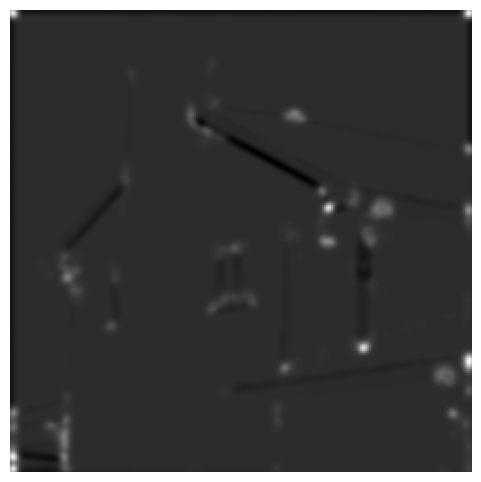

In [62]:
house2 = np.array(Image.open("img/house2.png"))
W=15
kappa = 0.04
R = computeR(house2,W, kappa)
imshow(house2)
imshow(R)
thres = np.mean(R)

3) Write in a few lines an interpretation of the results, explaining how the Harris response allows to detect and discriminate homogeneous areas, edges and corners.

Your answer...

## Exercise 2 : Harris corner detector
From the Harris response calculated at exercise 1, we will write all the functions needed for the Harris detector. Write the following functions: 

1) A function `thresholdR(R, thres)` that calculates and returns the binary thresholding $R_b$ of the response $R$ according to the threshold $thres$

In [63]:
def thresholdR(R, thres):
    """ Array[n, m] * float -> Array[n, m]
    """
    Rb = np.where(R>thres,1,0)
    return Rb

2) A function `Rnms(R, Rbin)` that performs a non-maximum supression from the response $R$ and the binarized response $R_{bin}$. It returns the image $R_{locmax}$ (same size as $R$) =1 where $R_{bin}=1$ and the pixel has a greater value $R$ than its 8 nearest neighbors.

**Bonus**: Write a faster version of the script using Numpy function `np.roll()`.

In [64]:
def imagePad(I,h):
    d = h.shape[0]
    x = int((d-1)/2)
    n = I.shape[0]
    m = I.shape[1]
    newI = np.zeros((n+d-1,m+d-1))

    for i in range(n):
        for j in range(m):
            newI[i+x][j+x] = I[i][j]
    return newI

def rnms(R,Rbin):
    """ Array[n, m] -> Array[n, m] 
    """
    Rlocmax = np.zeros(R.shape)
    R = imagePad(R, np.zeros((3,3)))
    for i in range(Rbin.shape[0]):
        for j in range(Rbin.shape[1]):
            if Rbin[i][j]== 1:
                X = np.array([R[i][j],R[i][j+1],R[i][j+2],
                              R[i+1][j], R[i+1][j+1],R[i+1][j+2],
                              R[i+2][j],R[i+2][j+1],R[i+2][j+2]])
                max = np.max(X)
                if R[i+1][j+1] == max:
                    Rlocmax[i][j]=1
    return Rlocmax

3) Write a function ``cornerDetector(image, scale, kappa, thresh)`` that returns an array of the same size as the image. The array takes two values: 1 where a corner is detected and 0 elsewhere.

In [65]:
def cornerDetector(image, scale, kappa, thres):
    """ Array[n, m]*float*float*float -> Array[n, m]
    """
    R = computeR(image,scale, kappa)
    Rbin = thresholdR(R,thres)
    Rlocmax = rnms(R,Rbin)
    return Rlocmax


4 ) Display the detected corners on the original image for the image ```img/house2.png```. Each detected corner will be displayed as a small red disk. You can use the functions ```np.nonzero()``` and ```plt.scatter()``` to that purpose.

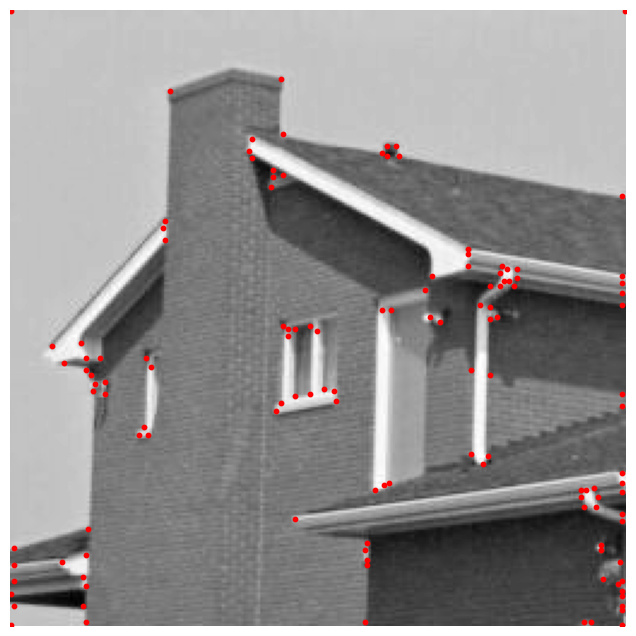

In [79]:
W=5
kappa = 0.04
R = computeR(house2,W, kappa)

thres = 0.01*np.max(R); 
Rlocmax = cornerDetector(house2,W,kappa,thres)
# imshow(Rlocmax)
# imshow(house2)
plt.figure(figsize=(8,8))
plt.imshow(house2, cmap="gray")
X,Y=np.nonzero(Rlocmax)
plt.scatter(Y, X, color="red", s=10)
plt.axis('off')
plt.title("")
plt.show()

5) Evaluate the performances of the corner detector. Try to find good values for Sigma and Threshold.

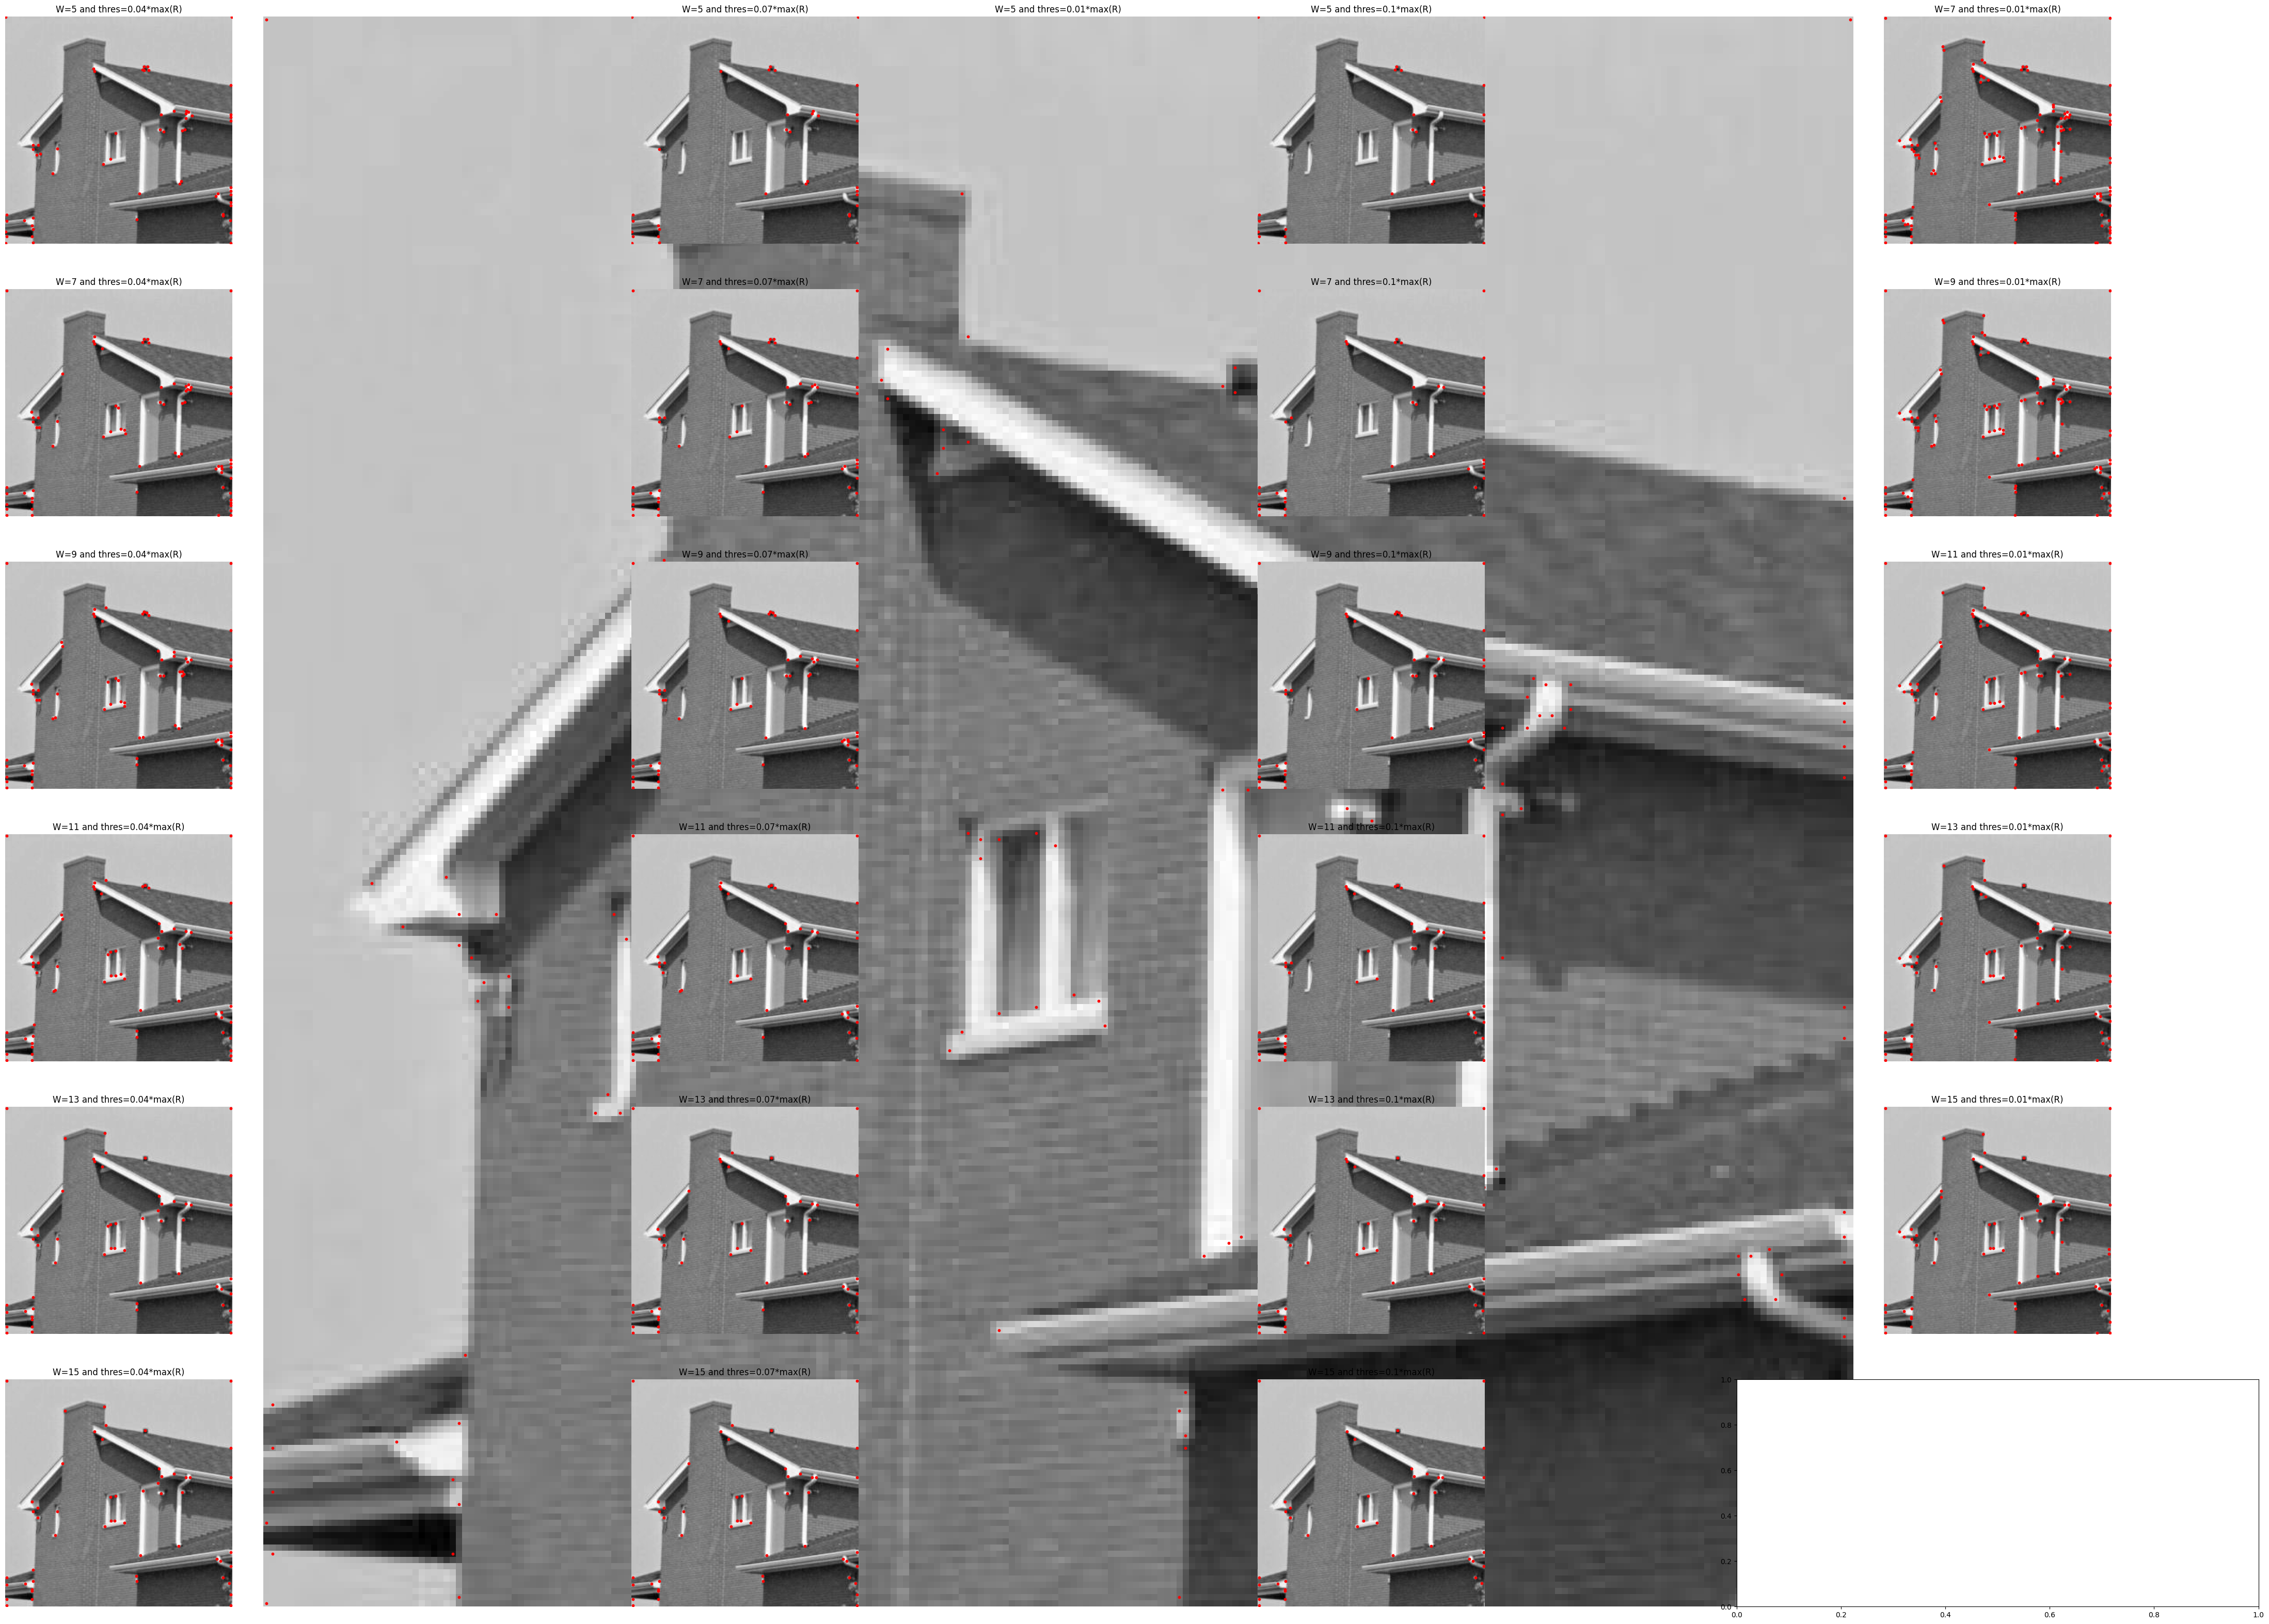

In [97]:
W = np.arange(5, 17,2)
thresholds = np.linspace(0.01, 0.1, 4)
kappa = 0.04
fig = plt.figure(figsize=(60, 40)) 
  
# setting values to rows and column variables 
rows = 6
columns = 4

i=0
for w in W:
    for threshold in thresholds:
        i+=1
        R = computeR(house2,w, kappa)

        thres = threshold*np.max(R); 
        Rlocmax = cornerDetector(house2,w,kappa,thres)
        # imshow(Rlocmax)
        # imshow(house2)
        # plt.figure(figsize=(8,8))
        plt.imshow(house2, cmap="gray")
        X,Y=np.nonzero(Rlocmax)
        plt.scatter(Y, X, color="red", s=10)
        plt.axis('off')
        title = "W=" + str(w) + " and thres=" + str(threshold) + "*max(R)"
        plt.title(title)
        fig.add_subplot(rows, columns, i) 


## Exercise 3 : Properties of Harris corner detector

The goal of this exercice is to study some invariance properties of Harris detector.

1) Write a script that detects the corners on the images ```img/toyHorse1.png``` and ```img/toyHorse2.png``` with a scale of 15 and appropriate threshold value. Display the detected corners on the images.

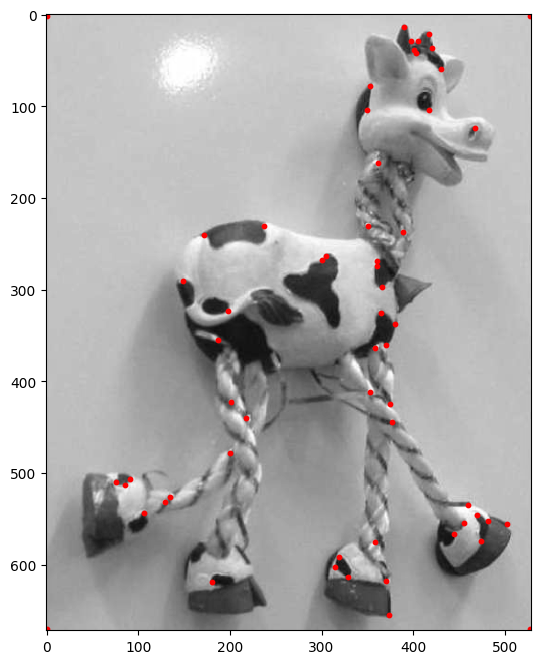

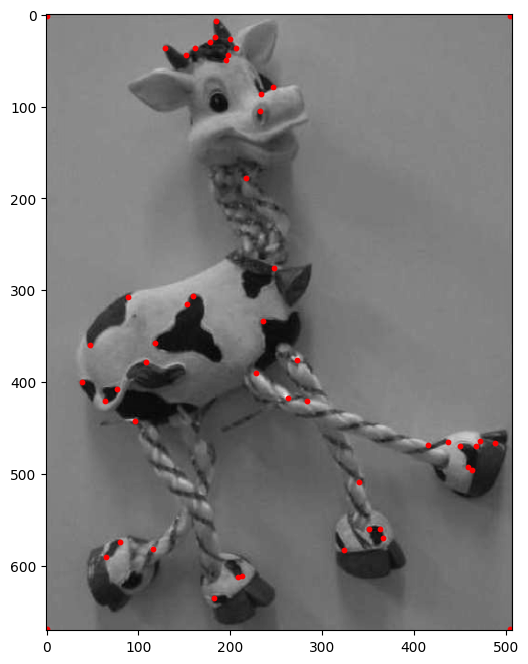

In [99]:
W=15
kappa=0.04
horse1 = np.array(Image.open("img/toyHorse1.png"))
horse2 = np.array(Image.open("img/toyHorse2.png"))
R_1 = computeR(horse1, W, kappa)
R_2 = computeR(horse2, W, kappa)
thres1 = 0.07*np.max(R_1)
thres2 = 0.07*np.max(R_2)
corner_horse1 = cornerDetector(horse1,W,kappa,thres1)
corner_horse2 = cornerDetector(horse2,W,kappa,thres2)

plt.figure(figsize=(8,8))
plt.imshow(horse1, cmap="gray")
X,Y=np.nonzero(corner_horse1)
plt.scatter(Y, X, color="red", s=10)
plt.show()

plt.figure(figsize=(8,8))
plt.imshow(horse2, cmap="gray")
X,Y=np.nonzero(corner_horse2)
plt.scatter(Y, X, color="red", s=10)
plt.show()

2) What are the dynamic ranges of these two images ?

Your answer...

3) What are the transformations beetween the two images ?

Your answer...

4) Using a fixed threshold, is the detection invariant to rotation ? To affine transformation of brightness ?

Your Answer

In [68]:
def rotateImage(I,a):
    """ Array*float -> Array 
        return a rotation of angle a (degree) of image I
    """
    return np.array(Image.fromarray(I).rotate(a, expand=True, fillcolor=127))

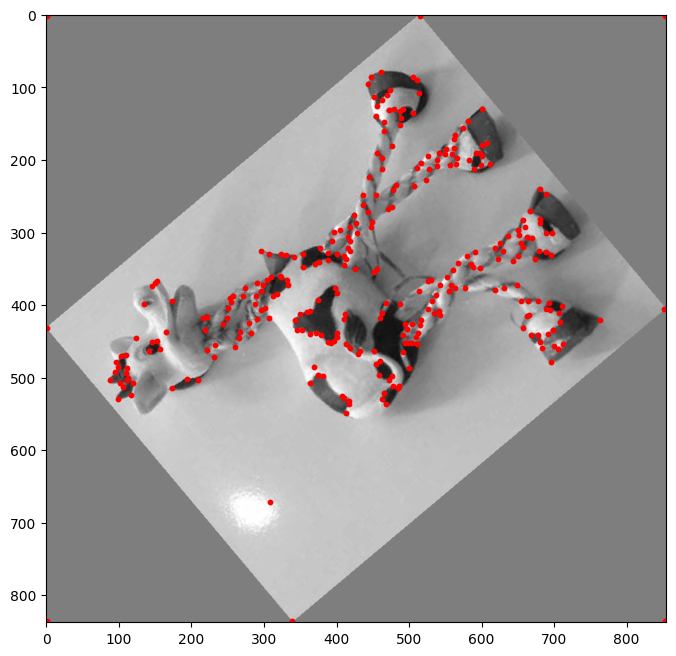

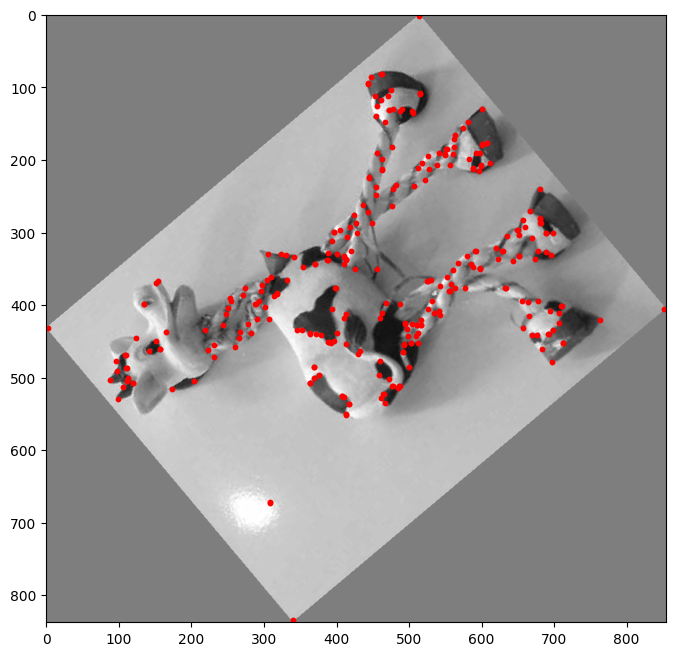

352


In [69]:
alpha = 130
newHorse = rotateImage(horse1, alpha)
# imshow(newHorse)
# imshow(horse1)
R_1 = cornerDetector(newHorse, 15, 0.04, 10000000)
R_2 = cornerDetector(horse1, 15, 0.04,10000000)
diff =0

R_2 = rotateImage(R_2, alpha)
R_2 = np.where(R_2==127,0,R_2)

plt.figure(figsize=(8,8))
plt.imshow(newHorse, cmap="gray")
X,Y=np.nonzero(R_1)
plt.scatter(Y, X, color="red", s=10)
plt.show()

plt.figure(figsize=(8,8))
plt.imshow(newHorse, cmap="gray")
X,Y=np.nonzero(R_2)
plt.scatter(Y, X, color="red", s=10)
plt.show()
for i in range(R_1.shape[0]):
    for j in range(R_1.shape[1]):
        if R_1[i][j] != R_2[i][j]:
            diff += 1
print(diff)

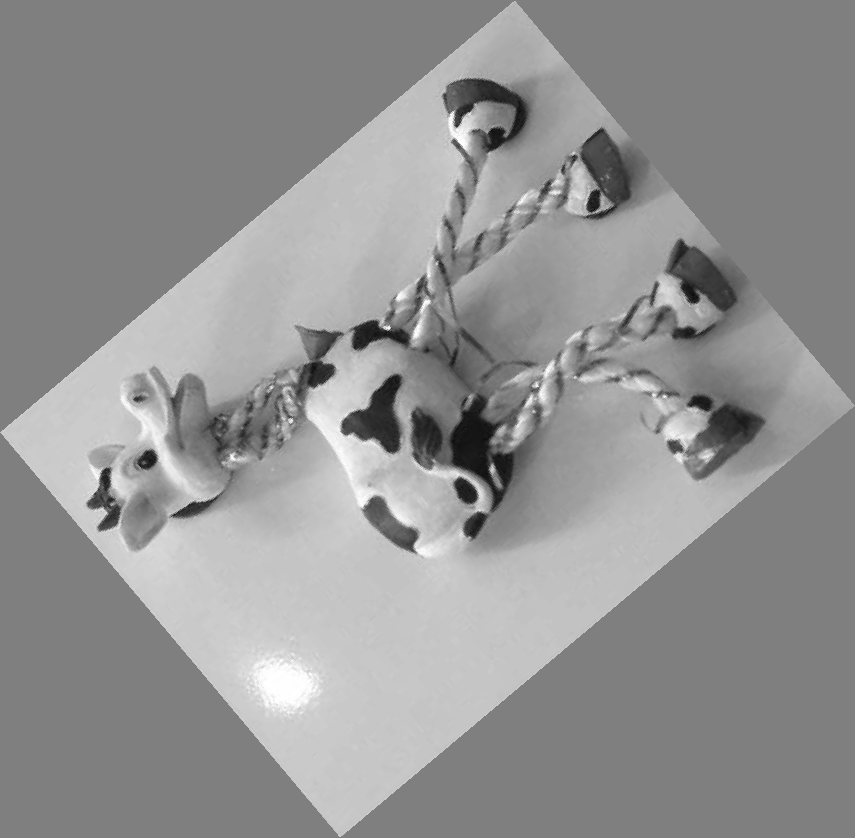

In [70]:
Image.fromarray(newHorse)

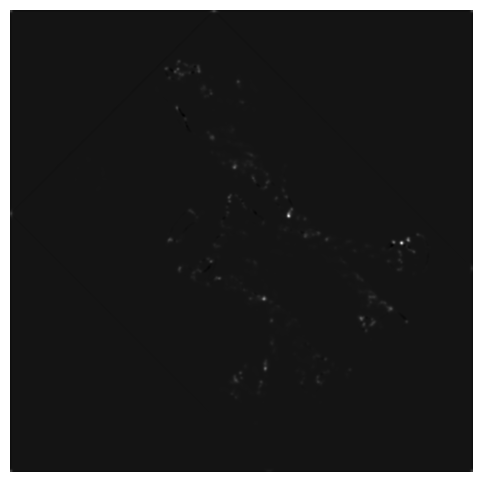

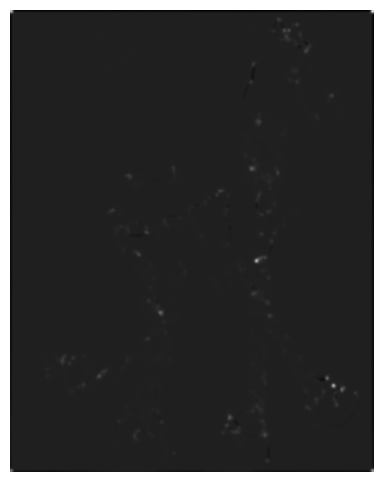

In [71]:
newHorse = rotateImage(horse1, 45)
R_1 = computeR(newHorse, 15, 0.04)
R_2 = computeR(horse1, 15, 0.04)
imshow(R_1)
imshow(R_2)

In [72]:
R_1.shape

(850, 851)

In [73]:
np.int16([1.60,1.4])

array([1, 1], dtype=int16)

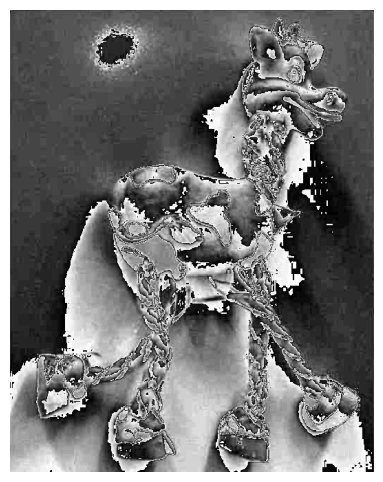

In [74]:
def affineImage(I,a,b):
    return a*I+b

newHorse = affineImage(horse1, 4,50)
imshow(newHorse)

R_1 = computeR(newHorse, 15,0.04)
R_2 = computeR(horse1, 15, 0.04)